In [ ]:
!pip install gymnasium stable-baselines3 numpy matplotlib torch

In [ ]:
# ============================================================
# IMPROVED PRECISION AGRICULTURE DRL MODEL
# With Better Reward Balancing
# ============================================================



import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import BaseCallback
import torch
import json
from typing import Dict, Tuple, Any
import warnings
warnings.filterwarnings('ignore')

print("✅ All packages installed successfully!")

# ============================================================
# IMPROVED AGRICULTURAL ENVIRONMENT
# ============================================================

class ImprovedAgricultureEnv(gym.Env):
    """
    Improved Agricultural Environment with better reward balance
    """
    metadata = {'render_modes': ['human']}

    def __init__(self, crop_type='wheat', max_steps=30):
        super(ImprovedAgricultureEnv, self).__init__()

        self.crop_type = crop_type
        self.max_steps = max_steps
        self.current_step = 0

        # STATE SPACE (11 variables)
        self.observation_space = spaces.Box(
            low=np.array([0, 0, 0, 0, 4.0, 0, -10, 0, 0, 0, 0], dtype=np.float32),
            high=np.array([100, 200, 200, 200, 9.0, 1.0, 50, 100, 1.0, 20, 3], dtype=np.float32),
            dtype=np.float32
        )

        # ACTION SPACE
        self.action_space = spaces.MultiDiscrete([5, 4])

        # Action mappings
        self.irrigation_options = [0, 5, 10, 15, 20]  # mm
        self.fertilizer_options = [0, 1, 2, 3]  # kg/acre

        # Optimal ranges
        self.optimal_moisture_range = (40, 70)
        self.optimal_n_range = (50, 150)
        self.optimal_p_range = (30, 100)
        self.optimal_k_range = (40, 120)
        self.optimal_ph_range = (6.0, 7.5)

        self.state = None
        self.total_water_used = 0
        self.total_fertilizer_used = 0
        self.crop_health_history = []

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        self.current_step = 0
        self.total_water_used = 0
        self.total_fertilizer_used = 0
        self.crop_health_history = []

        self.state = np.array([
            np.random.uniform(20, 50),   # Start with lower moisture
            np.random.uniform(30, 70),   # Start with lower nitrogen
            np.random.uniform(20, 60),
            np.random.uniform(30, 70),
            np.random.uniform(5.5, 7.5),
            0.0,
            np.random.uniform(20, 35),
            np.random.uniform(40, 80),
            np.random.uniform(0, 0.5),
            0.0,
            0.0
        ], dtype=np.float32)

        return self.state, {}

    def step(self, action):
        irrigation_amount = self.irrigation_options[int(action[0])]
        fertilizer_amount = self.fertilizer_options[int(action[1])]

        self.total_water_used += irrigation_amount
        self.total_fertilizer_used += fertilizer_amount

        moisture, n, p, k, ph, growth_stage, temp, humidity, rain_prob = self.state[:9]

        # Simulate rainfall
        rain_amount = 0
        if np.random.random() < rain_prob:
            rain_amount = np.random.uniform(5, 15)

        # Update soil moisture
        evaporation = np.random.uniform(3, 6) + (temp - 25) * 0.3
        moisture_gain = irrigation_amount * 0.7 + rain_amount
        new_moisture = moisture + moisture_gain - evaporation
        new_moisture = np.clip(new_moisture, 0, 100)

        # Update nutrients
        nutrient_uptake_rate = 0.5 + growth_stage * 0.8
        new_n = n + fertilizer_amount * 15 - nutrient_uptake_rate * 4
        new_p = p + fertilizer_amount * 8 - nutrient_uptake_rate * 2
        new_k = k + fertilizer_amount * 10 - nutrient_uptake_rate * 2.5

        new_n = np.clip(new_n, 0, 200)
        new_p = np.clip(new_p, 0, 200)
        new_k = np.clip(new_k, 0, 200)

        # Update pH
        ph_change = (fertilizer_amount - 1.5) * 0.05
        new_ph = np.clip(ph + ph_change, 4.0, 9.0)

        # Update growth stage
        growth_increment = 1.0 / self.max_steps
        if self._is_healthy(new_moisture, new_n, new_p, new_k, new_ph):
            growth_increment *= 1.5
        else:
            growth_increment *= 0.7  # Slow growth when not healthy
        new_growth_stage = min(growth_stage + growth_increment, 1.0)

        # Update weather
        new_temp = temp + np.random.uniform(-3, 3)
        new_temp = np.clip(new_temp, -10, 50)
        new_humidity = humidity + np.random.uniform(-10, 10)
        new_humidity = np.clip(new_humidity, 0, 100)
        new_rain_prob = np.random.uniform(0, 1)

        # Update state
        self.state = np.array([
            new_moisture, new_n, new_p, new_k, new_ph,
            new_growth_stage, new_temp, new_humidity, new_rain_prob,
            irrigation_amount, fertilizer_amount
        ], dtype=np.float32)

        # Calculate reward
        reward = self._calculate_improved_reward(
            new_moisture, new_n, new_p, new_k, new_ph,
            irrigation_amount, fertilizer_amount,
            rain_prob, rain_amount, new_growth_stage, temp
        )

        crop_health = self._calculate_crop_health(
            new_moisture, new_n, new_p, new_k, new_ph
        )
        self.crop_health_history.append(crop_health)

        self.current_step += 1
        terminated = self.current_step >= self.max_steps
        truncated = False

        info = {
            'crop_health': float(crop_health),
            'water_used': float(irrigation_amount),
            'fertilizer_used': float(fertilizer_amount),
            'rain_occurred': rain_amount > 0,
            'growth_stage': float(new_growth_stage)
        }

        return self.state, float(reward), terminated, truncated, info

    def _is_healthy(self, moisture, n, p, k, ph):
        moisture_ok = self.optimal_moisture_range[0] <= moisture <= self.optimal_moisture_range[1]
        n_ok = self.optimal_n_range[0] <= n <= self.optimal_n_range[1]
        p_ok = self.optimal_p_range[0] <= p <= self.optimal_p_range[1]
        k_ok = self.optimal_k_range[0] <= k <= self.optimal_k_range[1]
        ph_ok = self.optimal_ph_range[0] <= ph <= self.optimal_ph_range[1]
        return moisture_ok and n_ok and p_ok and k_ok and ph_ok

    def _calculate_crop_health(self, moisture, n, p, k, ph):
        health = 100.0

        if moisture < self.optimal_moisture_range[0]:
            health -= (self.optimal_moisture_range[0] - moisture) * 0.8
        elif moisture > self.optimal_moisture_range[1]:
            health -= (moisture - self.optimal_moisture_range[1]) * 0.4

        if n < self.optimal_n_range[0]:
            health -= (self.optimal_n_range[0] - n) * 0.3
        if p < self.optimal_p_range[0]:
            health -= (self.optimal_p_range[0] - p) * 0.2
        if k < self.optimal_k_range[0]:
            health -= (self.optimal_k_range[0] - k) * 0.2

        if not (self.optimal_ph_range[0] <= ph <= self.optimal_ph_range[1]):
            health -= 15

        return float(max(0, min(100, health)))

    def _calculate_improved_reward(self, moisture, n, p, k, ph,
                                   irrigation, fertilizer, rain_prob,
                                   rain_amount, growth_stage, temp):
        """
        IMPROVED REWARD FUNCTION with better balance
        """
        reward = 0.0

        # 1. STRONG reward for healthy crop (0-30 points)
        crop_health = self._calculate_crop_health(moisture, n, p, k, ph)
        reward += crop_health * 0.3

        # 2. BONUS for optimal conditions (0-20 points)
        if self.optimal_moisture_range[0] <= moisture <= self.optimal_moisture_range[1]:
            reward += 15
        if self.optimal_n_range[0] <= n <= self.optimal_n_range[1]:
            reward += 5

        # 3. PENALTY for deficiency (encourage action when needed)
        if moisture < 30:
            reward -= 20  # Strong penalty for drought
            if irrigation > 0:
                reward += 10  # Reward for taking action

        if n < 40:
            reward -= 15  # Strong penalty for nutrient deficiency
            if fertilizer > 0:
                reward += 8  # Reward for taking action

        # 4. Moderate resource consumption cost (reduced)
        reward -= irrigation * 0.15  # Reduced from 0.3
        reward -= fertilizer * 1.0   # Reduced from 2.0

        # 5. Penalty for rain waste
        if irrigation > 5 and rain_prob > 0.7:
            reward -= 10
        if irrigation > 5 and rain_amount > 0:
            reward -= 8

        # 6. Over-application penalty
        if moisture > 80:
            reward -= 12
        if n > 160:
            reward -= 15

        # 7. Growth bonus
        reward += growth_stage * 10

        # 8. Temperature adjustment
        if temp > 35 and irrigation > 0:
            reward += 5  # Bonus for irrigating in heat

        return float(reward)

    def render(self, mode='human'):
        if mode == 'human':
            print(f"\n{'='*50}")
            print(f"Step: {self.current_step}/{self.max_steps}")
            print(f"Moisture: {self.state[0]:.1f}%")
            print(f"NPK: {self.state[1]:.0f}/{self.state[2]:.0f}/{self.state[3]:.0f}")
            print(f"Crop Health: {self._calculate_crop_health(*self.state[:5]):.1f}%")
            print(f"{'='*50}\n")

# TEST ENVIRONMENT
print("\n🔬 Testing Improved Environment...")
env = ImprovedAgricultureEnv()
check_env(env, warn=True)
print("✅ Environment validation passed!")

# TRAIN THE MODEL
print("\n🚀 Starting Training...")

train_env = ImprovedAgricultureEnv()

model = PPO(
    "MlpPolicy",
    train_env,
    learning_rate=3e-4,
    n_steps=2048,
    batch_size=64,
    n_epochs=10,
    gamma=0.99,
    verbose=1,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

print(f"Training on: {model.device}")

model.learn(total_timesteps=150000, progress_bar=True)

print("\n✅ Training completed!")
model.save("improved_ppo_agriculture")

# EVALUATE
print("\n📊 Evaluating...\n")

eval_env = ImprovedAgricultureEnv()
episode_rewards = []
episode_water = []
episode_fert = []
episode_health = []

for ep in range(10):
    obs, _ = eval_env.reset()
    done = False
    ep_reward = 0
    water = 0
    fert = 0
    healths = []

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = eval_env.step(action)
        done = terminated or truncated
        ep_reward += reward
        water += info['water_used']
        fert += info['fertilizer_used']
        healths.append(info['crop_health'])

    episode_rewards.append(ep_reward)
    episode_water.append(water)
    episode_fert.append(fert)
    episode_health.append(np.mean(healths))

    print(f"Ep {ep+1}: Reward={ep_reward:.1f}, Water={water:.0f}mm, Fert={fert:.1f}kg, Health={np.mean(healths):.1f}%")

print(f"\n📈 RESULTS:")
print(f"Avg Reward: {np.mean(episode_rewards):.1f}")
print(f"Avg Water: {np.mean(episode_water):.1f}mm")
print(f"Avg Fertilizer: {np.mean(episode_fert):.2f}kg")
print(f"Avg Health: {np.mean(episode_health):.1f}%")

# TEST SCENARIOS
def get_recommendation(moisture, n, p, k, ph, growth, temp, humidity, rain_prob):
    state = np.array([moisture, n, p, k, ph, growth, temp, humidity, rain_prob, 0, 0], dtype=np.float32)
    action, _ = model.predict(state, deterministic=True)

    irrigation = eval_env.irrigation_options[int(action[0])]
    fertilizer = eval_env.fertilizer_options[int(action[1])]

    return {
        "irrigation_mm": irrigation,
        "fertilizer_kg": fertilizer,
        "soil_moisture": moisture,
        "nitrogen": n
    }

print("\n🧪 TESTING SCENARIOS:\n")

print("Scenario 1: DRY SOIL, LOW NUTRIENTS")
rec1 = get_recommendation(25, 35, 25, 30, 6.5, 0.4, 32, 45, 0.1)
print(json.dumps(rec1, indent=2))

print("\nScenario 2: OPTIMAL CONDITIONS")
rec2 = get_recommendation(55, 90, 60, 80, 6.9, 0.6, 28, 60, 0.3)
print(json.dumps(rec2, indent=2))

print("\nScenario 3: HIGH RAIN PROBABILITY")
rec3 = get_recommendation(45, 70, 50, 70, 6.7, 0.5, 26, 75, 0.9)
print(json.dumps(rec3, indent=2))

print("\n✅ Training and evaluation complete!")


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


✅ All packages installed successfully!

🔬 Testing Improved Environment...
✅ Environment validation passed!

🚀 Starting Training...
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Output()

Training on: cuda
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 30       |
|    ep_rew_mean     | 158      |
| time/              |          |
|    fps             | 420      |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 30          |
|    ep_rew_mean          | 190         |
| time/                   |             |
|    fps                  | 343         |
|    iterations           | 2           |
|    time_elapsed         | 11          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.016124222 |
|    clip_fraction        | 0.221       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.98       |
|    explained_variance   | -0.00117    |
|    learnin


✅ Training completed!

📊 Evaluating...

Ep 1: Reward=1161.0, Water=85mm, Fert=6.0kg, Health=86.5%
Ep 2: Reward=1105.2, Water=100mm, Fert=10.0kg, Health=84.9%
Ep 3: Reward=995.1, Water=95mm, Fert=7.0kg, Health=85.9%
Ep 4: Reward=851.8, Water=70mm, Fert=8.0kg, Health=82.5%
Ep 5: Reward=906.8, Water=95mm, Fert=6.0kg, Health=81.4%
Ep 6: Reward=1230.0, Water=30mm, Fert=5.0kg, Health=92.9%
Ep 7: Reward=1293.9, Water=110mm, Fert=7.0kg, Health=83.5%
Ep 8: Reward=798.0, Water=140mm, Fert=7.0kg, Health=79.7%
Ep 9: Reward=465.7, Water=30mm, Fert=7.0kg, Health=73.5%
Ep 10: Reward=1151.0, Water=145mm, Fert=9.0kg, Health=92.1%

📈 RESULTS:
Avg Reward: 995.8
Avg Water: 90.0mm
Avg Fertilizer: 7.20kg
Avg Health: 84.3%

🧪 TESTING SCENARIOS:

Scenario 1: DRY SOIL, LOW NUTRIENTS
{
  "irrigation_mm": 5,
  "fertilizer_kg": 1,
  "soil_moisture": 25,
  "nitrogen": 35
}

Scenario 2: OPTIMAL CONDITIONS
{
  "irrigation_mm": 5,
  "fertilizer_kg": 0,
  "soil_moisture": 55,
  "nitrogen": 90
}

Scenario 3: HIGH RAIN

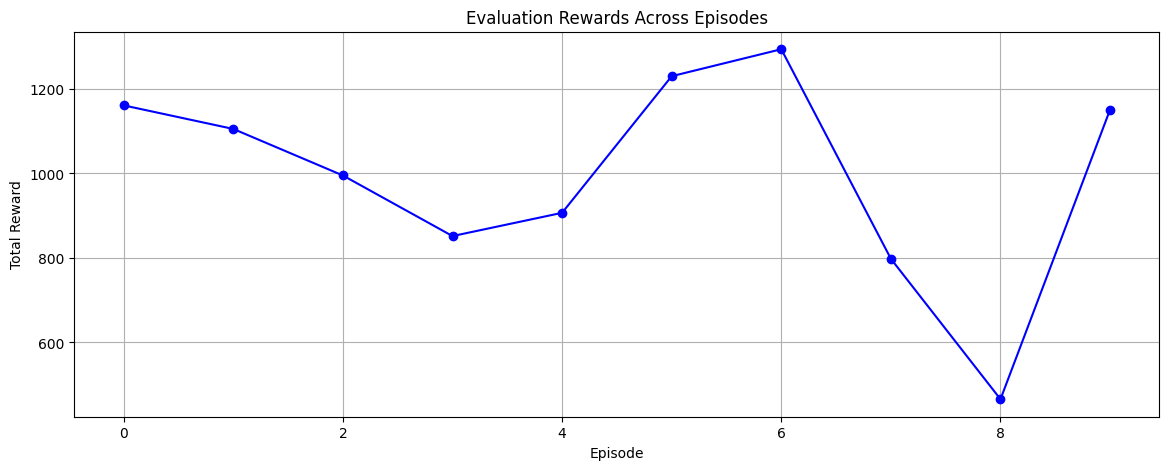

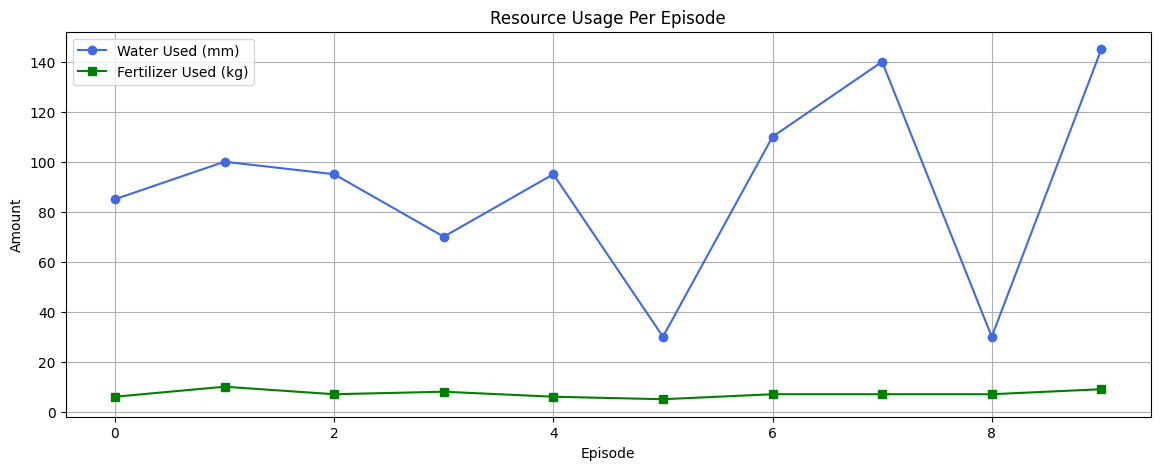

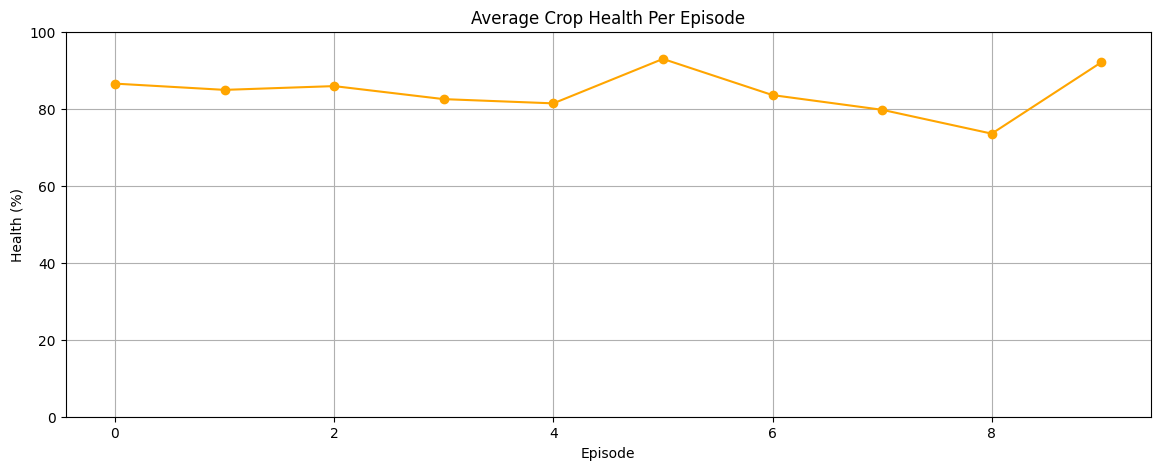

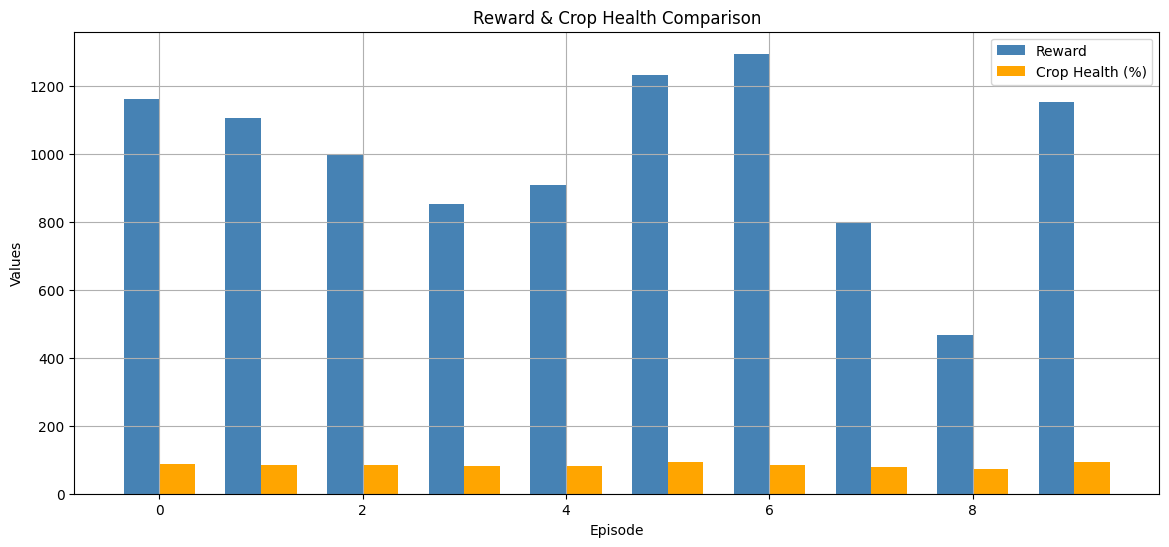

✅ Visualization completed successfully!


In [ ]:
# ============================================================
# 📊 VISUALIZATION FOR DRL AGRICULTURE MODEL
# ============================================================

import matplotlib.pyplot as plt
import numpy as np

# 1️⃣ Plot Evaluation Rewards
plt.figure(figsize=(14, 5))
plt.plot(episode_rewards, marker='o', color='blue')
plt.title("Evaluation Rewards Across Episodes")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()

# 2️⃣ Plot Water & Fertilizer Usage
plt.figure(figsize=(14, 5))
plt.plot(episode_water, marker='o', label='Water Used (mm)', color='royalblue')
plt.plot(episode_fert, marker='s', label='Fertilizer Used (kg)', color='green')
plt.title("Resource Usage Per Episode")
plt.xlabel("Episode")
plt.ylabel("Amount")
plt.legend()
plt.grid(True)
plt.show()

# 3️⃣ Crop Health Visualization
plt.figure(figsize=(14, 5))
plt.plot(episode_health, marker='o', color='orange')
plt.title("Average Crop Health Per Episode")
plt.xlabel("Episode")
plt.ylabel("Health (%)")
plt.ylim([0, 100])
plt.grid(True)
plt.show()

# 4️⃣ Combined Bar Chart (Reward vs Health)
plt.figure(figsize=(14, 6))
bar_width = 0.35
x = np.arange(len(episode_rewards))

plt.bar(x - bar_width/2, episode_rewards, width=bar_width, label="Reward", color='steelblue')
plt.bar(x + bar_width/2, episode_health, width=bar_width, label="Crop Health (%)", color='orange')

plt.title("Reward & Crop Health Comparison")
plt.xlabel("Episode")
plt.ylabel("Values")
plt.legend()
plt.grid(True)
plt.show()

print("✅ Visualization completed successfully!")


In [ ]:
# ============================================================
# 📥 SAVE & DOWNLOAD MODEL + ENV CONFIG (GOOGLE COLAB)
# ============================================================

import json
from google.colab import files

# 1️⃣ SAVE MODEL FILE
model_path = "improved_ppo_agriculture.zip"
model.save(model_path)
print(f"✅ Model saved as: {model_path}")

# 2️⃣ SAVE ENVIRONMENT PARAMETERS
env_config = {
    "observation_space_low": eval_env.observation_space.low.tolist(),
    "observation_space_high": eval_env.observation_space.high.tolist(),
    "irrigation_options": eval_env.irrigation_options,
    "fertilizer_options": eval_env.fertilizer_options,
    "optimal_ranges": {
        "moisture": eval_env.optimal_moisture_range,
        "nitrogen": eval_env.optimal_n_range,
        "phosphorus": eval_env.optimal_p_range,
        "potassium": eval_env.optimal_k_range,
        "ph": eval_env.optimal_ph_range
    }
}

with open("env_config.json", "w") as f:
    json.dump(env_config, f, indent=2)

print("✅ Environment configuration saved as env_config.json")

# 3️⃣ DOWNLOAD FILES TO LOCAL SYSTEM
print("\n⬇️ Downloading files...")

files.download(model_path)
files.download("env_config.json")

print("🎉 All files downloaded successfully!")


✅ Model saved as: improved_ppo_agriculture.zip
✅ Environment configuration saved as env_config.json

⬇️ Downloading files...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

🎉 All files downloaded successfully!
